# 0. 미니프로젝트: 카페사진 감성분석

이 프로젝트는 카페사진을 보고 그 사진에 대해서 평가를 해주는 프로그램을 만들어 보고 싶어서 시작하게 되었다. 

카페의 감성을 어떻게 평가할 지에 대해서는 몇개의 방안이 있었는데, 보류된 것 중 하나는 사진의 객체를 검출해서 그 객체로 사진의 감성을 평가하는 것이었다. YOLO알고리즘을 사용해봤는데, 사진의 객체를 검출해도 막상 감성을 판단하기는 쉽지 않았다. 

그래서 더 직관적으로 알 수 있는 사진의 색으로 카페의 분위기를 판단하기로 결정했다.

# 0-1 색을 검출하기

https://inyl.github.io/programming/2017/07/31/opencv_image_color_cluster.html
위 링크에서 색을 군집화 하는 코드를 발견 했다. 

군집화 기법을 공부했기 때문에 코드를 이해하고 가져와서 작성했다.
    
아래 코드는 사진의 주요 색상과 그 색상의 비율을 뽑아내는 코드이다.
   

In [2]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_img_clustering(img, k=4):
    """ 
    이미지주소를 받으면 색데이터를 k=4인 클러스터링을 실행한다. 
    img_data를 리턴하며, img_data는 cluster_centers_와 색이 포함된 비율을 담은 리스트를 리턴한다.
    [[R,G,B,%],[R,G,B,%],[R,G,B,%],[R,G,B,%]] 형태로 저장되어 있음.
    """
    img_data = []
    temp = []
    
    img = cv2.imread(str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # img[x] 를 하면 x좌표에 해당하는 색이 추출된다고 할 수 있다.
    # 사진 데이터를 클러스터링 하기위해서 행렬로 만들어 주는 것이다.
    img = img.reshape((img.shape[0] * img.shape[1], 3))
    print(img.shape)
    # 4개로 클러스터링
    clt = KMeans(n_clusters = k)
    clt.fit(img)

    temp=clt.cluster_centers_
    
    # 색이 포함된 비율을 저장하는 코드
    (hist, _) = np.histogram(clt.labels_, bins=k)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    for i,per in enumerate(hist):
        li = list(temp[i])
        li = list(np.round(li, 2))
        li.append(round(per,2))
        img_data.append(li)
        
    return (img_data)
    
    
img__ = np.array(read_img_clustering("cafe/1.jpg"))
print(img__)
print(img__.shape)

(48400, 3)
[[5.2450e+01 2.5060e+01 5.1840e+01 3.2000e-01]
 [1.3244e+02 1.0118e+02 1.5209e+02 4.5000e-01]
 [1.3786e+02 1.2070e+01 2.0582e+02 1.3000e-01]
 [2.0693e+02 1.7354e+02 1.6563e+02 1.0000e-01]]
(4, 4)


처음에 나는 위와 같이 사진데이터를 가공하고 모델을 fit 하려고 했다. 하지만 오류가 떴다. 
<br> 아무리 생각해도 모르겠었는데, 나의 데이터의 형태가 matrix가 아니였다.<Br>
    나의 데이터는 100 x 4 x 4 형태의 tensor였다. (학습데이터가 100개이다.)

그래서 나에게는 두가지 선택지가 있다.
1. 행렬로 데이터 셋을 만든다. (데이터가 소실될 수도 있을 것 같다.)
2. 텐서플로우를 이용한 클러스터링 

어차피 나는 시간이 많은 휴학생이니 둘다 공부해서 해보자.

# 1. 데이터셋 크기 변환을 통한 sklearn 모델학습

## 1-1 tensor 를 행렬로 변환해서 클러스터링

In [19]:
# 원래 사진 한개의 데이터가 4 x 4 크기의 행렬 이었는데 이를 16 크기의 벡터로 바꿨다. 
# 이렇게 되면 컬럼이 16개 되니 차원축소를 수행해야 할 것 같다. (나중에 깨달았지만 아니다.)
import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def read_img_clustering(img, k=4):
    """ 
    이미지주소를 받으면 색데이터를 k=4인 클러스터링을 실행한다. 
    img_data를 리턴하며, img_data는 cluster_centers_와 색이 포함된 비율을 담은 리스트를 생성.
    [[R,G,B,%],[R,G,B,%],[R,G,B,%],[R,G,B,%]] 형태로 저장되어 있음.
    이를 데이터 프레임으로 변환해서 리턴함.
    """
    img_data = []
    temp = []
    
    img = cv2.imread(str(img))
        
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # img[x] 를 하면 x좌표에 해당하는 색이 추출된다고 할 수 있다.
    img = img.reshape((img.shape[0] * img.shape[1], 3))

    # 4개로 클러스터링
    clt = KMeans(n_clusters = k)
    clt.fit(img)

    temp=clt.cluster_centers_
    
    # 색이 포함된 비율을 저장하는 코드
    (hist, _) = np.histogram(clt.labels_, bins=k)

    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()

    for i,per in enumerate(hist):
        li = list(temp[i])
        li = list(np.round(li, 2))
        li.append(round(per,2))
        img_data.append(li)
    
    img_data.sort(key=lambda x: -x[3])
    
    img_data = pd.DataFrame(np.array(img_data).reshape(1,16))
    return (img_data)
    

def make_df(start, end):
    """
    사진이 cafe/ 폴더에 num.jpg의 형태로 저장되어 있다. ex) 1.jpg, 2.jpg ...
    make_df함수는 start~end 까지의 이미지의 데이터를 불러오고 이것들을 데이터프레임으로 만들어서 반환해준다.
    
    """
    
    # 최종적으로 리턴하게 될 이미지의 데이터 프레임
    col_names = ['R1', 'G1', 'B1', 'per1','R2', 'G2', 'B2', 'per2','R3', 'G3', 'B3', 'per3','R3', 'G3', 'B3', 'per3']
    img_df = pd.DataFrame()
    
    for i in range(start, end+1):
        # cafe 폴더에 정수로 저장된 이미지를 불러온다. 
        clustered_img = "cafe/"+str(i)+".jpg"
        data_df = read_img_clustering(clustered_img)
        data_df.rename({0: i},axis=0, inplace=True)
        img_df = pd.concat([img_df,data_df])
        
    img_df.rename(columns = lambda x: col_names[int(x)], inplace=True)
    return img_df

img_df = make_df(1,100)

In [20]:
# 아래와 같은 데이터 프레임을 얻었다.
img_df.head()

,R1,G1,B1,per1,R2,G2,B2,per2,R3,G3,B3,per3,R3,G3,B3,per3
1,132.43,101.19,152.05,0.45,52.41,25.03,51.80,0.32,137.75,12.09,205.68,0.13,206.89,173.46,165.66,0.10
2,21.05,20.25,11.53,0.31,118.08,129.07,110.16,0.24,70.32,67.67,47.67,0.23,183.85,188.23,166.79,0.22
3,31.71,15.71,12.33,0.38,176.40,143.40,112.27,0.27,99.06,74.81,65.64,0.18,219.51,206.00,193.23,0.17
4,162.88,148.04,141.31,0.29,120.22,102.97,87.98,0.27,193.33,185.90,191.51,0.25,49.09,35.80,25.97,0.19
5,169.44,143.98,128.23,0.31,55.67,41.46,33.77,0.29,119.25,91.17,75.30,0.28,219.18,205.48,177.34,0.13


짝짝짝

구글에서 퍼온 카페 사진 색상 데이터 프레임이 완성 되었다.

이제 이를 통해서 모델학습을 하면 될 것 같다. 

나에게는 두가지 아이디어가 있다.

1. 분류 기법


2. 저 데이터를 군집화 해서 가까운 군집에 포함 시켜버리는 방법

~~2번 방법을 처음에 생각했는데, 2번 방법은 아직 공부해본적이 없다. (그냥 아예 없는 기법일수도 있다.)~~

데이터는 현재 가장 높은 비중을 차지하는 색부터 차례대로 나타냈다.

## 1-2 차원축소

컬럼 16개를 사용하는건 말이 안된다... 차원축소를 해보자

In [6]:
from sklearn.decomposition import PCA

# 차원을 두개로 축소하는 경우
pca2 = PCA(n_components=2)

img_pca2 = pca2.fit_transform(img_df)

img_pca2 = pd.DataFrame(img_pca2, columns=['pca_component_1', 'pca_component_2'])

print(img_pca2.head())
print(pca2.explained_variance_ratio_)

   pca_component_1  pca_component_2
0       -97.748764       -26.559192
1      -167.153382        72.453018
2      -172.303251        85.685490
3       156.912135      -143.653017
4      -107.337507        23.714065
[0.49215682 0.18963501]


In [7]:
# 차원을 세개로 축소하는 경우
pca3 = PCA(n_components=3)

img_pca3 = pca3.fit_transform(img_df)

img_pca3 = pd.DataFrame(img_pca3, columns=['pca_component_1', 'pca_component_2','pca_component_3'])

print(img_pca3.head())
print(pca3.explained_variance_ratio_)

   pca_component_1  pca_component_2  pca_component_3
0       -97.748764       -26.559192      -117.306737
1      -167.153382        72.453018       104.049396
2      -172.303251        85.685490       121.428034
3       156.912135      -143.653017        -4.420295
4      -107.337507        23.714065      -144.846720
[0.49215682 0.18963501 0.14469556]


In [23]:
# 차원을 네개로 축소하는 경우
pca4 = PCA(n_components=4)

img_pca4 = pca4.fit_transform(img_df)

img_pca4 = pd.DataFrame(img_pca4, columns=['pca_component_1', 'pca_component_2','pca_component_3','pca_component_4'])

print(img_pca4.head())
print(pca4.explained_variance_ratio_)

   pca_component_1  pca_component_2  pca_component_3  pca_component_4
0       -95.595990       -41.976990      -117.111018        -1.595119
1      -166.964132        81.706307        91.785469       -57.436147
2      -171.191070        95.135256       106.691329        15.828700
3       158.911090      -144.388523         9.232269       -40.849097
4      -104.859311         3.423672      -148.883981         2.383773
[0.4896947  0.18376028 0.15268461 0.08371911]


In [24]:
# 차원을 다섯개로 축소하는 경우
pca4 = PCA(n_components=5)

img_pca5 = pca4.fit_transform(img_df)

img_pca5 = pd.DataFrame(img_pca5, columns=['pca_component_1', 'pca_component_2','pca_component_3','pca_component_4', 'pca_component_5'])

print(img_pca5.head())
print(pca4.explained_variance_ratio_)

   pca_component_1  pca_component_2  pca_component_3  pca_component_4  \
0       -95.595990       -41.976990      -117.111018        -1.595119   
1      -166.964132        81.706307        91.785469       -57.436147   
2      -171.191070        95.135256       106.691329        15.828700   
3       158.911090      -144.388523         9.232269       -40.849097   
4      -104.859311         3.423672      -148.883981         2.383773   

   pca_component_5  
0        83.682785  
1        -2.170502  
2       -19.037689  
3        -7.119774  
4       -26.496126  
[0.4896947  0.18376028 0.15268461 0.08371911 0.03374645]


차원축소를 해봤다. 5개로 축소할 때 분산이 95% 이상이 나오기 때문에 여기까지 해도 될 것 같다. 

pca2/3/4/5 에 대해서 다 학습해 볼 것이다.

----
한가지 의문이 들었다.

차원축소는 train set에서만 수행됐는데, test를 할 때는 어떻게 해야할까? 나는 이미지를 넣으면 자동적으로 키워드가 출력되는 api를 만들고 싶었던 것이기 때문에 아주 중요한 문제다.
중요한 문젠데.. 잘 모르겠다..

이러면 의미가 없는거 아닐까?

구글링으로 못찾았다.. 일단 차원축소를 진행하지 않고 진행해보자.

뒤늦게 깨달은 사실인데, 나는 어차피 로지스틱회귀를 사용하기 때문에 차원은 크게 상관이 없을 것 같다. (정확하진 않은 뇌피셜이다)

## 1-3 Label 설정

분류를 할 것이니 클래스를 정해야 한다. <br>
학습 데이터가 많지 않으니 레이블은 5개 정도가 적절하지 않을까..?

- 0: 힙한/빈티지한
- 1: 귀여운/예쁜
- 2: 고급스러운/아늑한/편한
- 3: 푸른/시원한
- 4: 모던한/깔끔한/평범한

수제작업으로 레이블을 추가해주자. (전적으로 개인적인 감상이다.)

In [25]:
label = [0,3,2,4,2,4,3,3,4,3, # ~10
         3,2,1,0,1,2,2,1,2,4, # ~20
         4,4,4,4,4,0,2,4,4,4, # ~30
         1,1,1,1,1,1,1,1,2,2, # ~40
         2,2,2,2,2,2,2,2,2,3, # ~50
         1,1,1,1,1,1,1,1,1,3, # ~60
         3,3,4,2,3,3,3,3,3,3, # ~70
         3,3,3,3,3,0,0,0,0,0, # ~80
         0,0,0,0,0,0,0,0,0,0, # ~90
         0,0,0,4,4,4,4,4,4,4,] # ~100

img_pca2['target'] = label
img_pca3['target'] = label
img_pca4['target'] = label
img_pca5['target'] = label

In [26]:
# 아래와 같은 데이터를 얻었다.
img_df['target'] = label
img_df

,R1,G1,B1,per1,R2,G2,B2,per2,R3,G3,B3,per3,R3,G3,B3,per3,target
1,132.43,101.19,152.05,0.45,52.41,25.03,51.80,0.32,137.75,12.09,205.68,0.13,206.89,173.46,165.66,0.10,0
2,21.05,20.25,11.53,0.31,118.08,129.07,110.16,0.24,70.32,67.67,47.67,0.23,183.85,188.23,166.79,0.22,3
3,31.71,15.71,12.33,0.38,176.40,143.40,112.27,0.27,99.06,74.81,65.64,0.18,219.51,206.00,193.23,0.17,2
4,162.88,148.04,141.31,0.29,120.22,102.97,87.98,0.27,193.33,185.90,191.51,0.25,49.09,35.80,25.97,0.19,4
5,169.44,143.98,128.23,0.31,55.67,41.46,33.77,0.29,119.25,91.17,75.30,0.28,219.18,205.48,177.34,0.13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,151.03,153.97,156.31,0.38,103.06,104.73,109.18,0.23,39.87,39.03,42.51,0.21,220.13,217.25,213.40,0.18,4
97,202.69,182.19,156.76,0.42,225.03,221.15,212.56,0.24,158.66,132.77,104.22,0.23,118.66,85.15,49.44,0.10,4
98,234.74,237.57,236.99,0.39,210.76,211.89,206.52,0.36,177.00,173.75,161.09,0.17,130.77,114.19,91.24,0.07,4
99,124.16,106.50,84.92,0.36,165.72,150.73,132.95,0.26,62.75,48.53,33.11,0.20,215.10,199.99,180.59,0.18,4


## 1-4 모델 평가

----------
내가 기획한 프로젝트는 애초에 사진의 색을 보고 여러가지 키워드를 알려주는 프로젝트 였다. <br>
그렇기 때문에 단순히 모델의 예측 Label과 내가 지정한 Label 의 정확도만을 보고 예측성능이 낮다고 할 수 없다.<br>
왜냐하면 내가 애초에 설정한 사진의 분위기가 나의 주관적인 감성이기 때문에 모델이 학습해서 예측한 것과는 다를 수 있기 때문이다. <br>


또한 내가 의도적으로 여러 분위기가 느껴지는 사진도 넣어놨기 때문에 단순히 예측성공 비율만으로 모델을 평가할 수는 없다.

그래서 이 아래에서는 내 생각과 다르게 예측한 사진들의 예측 결과를 보고, predict_proba를 통해서 어떻게 예측했는지도 보고 나의 모델을 평가해볼 것이다.

In [27]:
# 내가 index를 1부터 100까지 했는데 데이터프레임이 생성될때는 0~99까지 로 생성되서 인덱스를 변환해줘야한다. 
# 앞으로는 0부터 하자.

# 아래는 편하게 인덱스를 변환하기 위해서 미리 만들어둔 dic 이다.
change_index_dic = {}
for i in range(1, 101):
    change_index_dic[i-1]= i

model = LogisticRegression(max_iter=1000)
model.fit(X,y)

LogisticRegression(max_iter=1000)

-----
학습과 평가를 같은 데이터셋으로 해서 과대적합 문제는 있을 수 있지만... 

지금은 예측성능을 단순 예측성공 비율로 평가하는게 아니기 때문에 일단 해본다.

~~사실 데이터셋 모으기 귀찮다.~~

-----

In [28]:
# 모델이 각 Label을 예측한 확률을 받아서 데이터프레임으로 저장해준다. 
# 인덱스도 1~100으로 변환해준다
predict_proba = model.predict_proba(img_df.iloc[: , :-1])
predict_proba = pd.DataFrame(np.round(predict_proba,2))
predict_proba.rename(change_index_dic, inplace=True)

# 모델이 예측한 Label을 받아서 데이터프레임으로 저장해준다.
# 인덱스도 1~100으로 변환해준다
predict = model.predict(img_df.iloc[:,:-1])
predict = pd.DataFrame(predict)
predict.rename(change_index_dic, inplace=True)

#img_df 에 predict 컬럼을 만들고 predict 데이터프레임을 넣어준다
img_df['predict'] = predict

# img_df에서 모델이 예측한 Label과 내가 지정한 Label이 다른 (즉, 모델이 잘못 예측한) 데이터들만 뽑아서 accuracy에 저장한다.
accuracy = img_df[img_df['target'] != img_df['predict']][['target','predict']]

index= accuracy.index


error = len(accuracy)

print("당연히 train, test가 같은 데이터 셋으로 이루어져서 cv교차검증보다는 예측성능이 높다. 예측성능은 {}% 이다".format(100-error))

당연히 train, test가 같은 데이터 셋으로 이루어져서 cv교차검증보다는 예측성능이 높다. 예측성능은 84% 이다


-----
이제 내가 지정한 Label, 모델 예측 Label, 모델이 다르게 예측한 데이터의 predict_probability를 보기 좋게 데이터 프레임으로 만들어보자.

In [29]:
accuracy = pd.merge(accuracy, predict_proba, left_index=True, right_index=True, how='left')

In [30]:
accuracy 

,target,predict,0,1,2,3,4
10,3,4,0.00,0.00,0.00,0.33,0.66
16,2,0,0.53,0.02,0.46,0.00,0.00
27,2,0,0.71,0.05,0.23,0.00,0.00
35,1,0,0.55,0.04,0.42,0.00,0.00
42,2,0,0.43,0.13,0.40,0.01,0.04
44,2,3,0.12,0.22,0.30,0.33,0.03
48,2,3,0.12,0.01,0.07,0.71,0.09
49,2,3,0.08,0.00,0.39,0.53,0.01
50,3,2,0.10,0.01,0.84,0.03,0.02
67,3,2,0.43,0.04,0.50,0.02,0.01


내가 지정한 Label을 모델이 20%이상으로만 예측해도 성공적인 예측이라고 생각했다.<br>
20% 이상인 이유는, 총 Label이 5개이기 때문에 유의미한 예측을 하기 위해서는 20% 이상의 예측이 나와야 한다고 생각했다.

In [32]:
for i in accuracy.index:
    target = accuracy.loc[i, 'target']
    if accuracy.loc[i, target] > 0.2:
        accuracy.loc[i,'correct_predict?'] = True
    else:
        accuracy.loc[i, 'correct_predict?'] = False

In [33]:
accuracy

,target,predict,0,1,2,3,4,correct_predict?
10,3,4,0.00,0.00,0.00,0.33,0.66,True
16,2,0,0.53,0.02,0.46,0.00,0.00,True
27,2,0,0.71,0.05,0.23,0.00,0.00,True
35,1,0,0.55,0.04,0.42,0.00,0.00,False
42,2,0,0.43,0.13,0.40,0.01,0.04,True
44,2,3,0.12,0.22,0.30,0.33,0.03,True
48,2,3,0.12,0.01,0.07,0.71,0.09,False
49,2,3,0.08,0.00,0.39,0.53,0.01,True
50,3,2,0.10,0.01,0.84,0.03,0.02,False
67,3,2,0.43,0.04,0.50,0.02,0.01,False


True를 한 예측성능

In [36]:
correct_predict = accuracy['correct_predict?'].value_counts()[True]
print("당연히 과대적합 이슈가 있지만, 그걸 배제하고 보면 모델의 정확도가 대략 {}%가 된다고 생각할 수 있을 것 같다.".format(100-error+correct_predict))

당연히 과대적합 이슈가 있지만, 그걸 배제하고 보면 모델의 정확도가 대략 93%가 된다고 생각할 수 있을 것 같다.


## 1-5 사진의 감성을 키워드로 나타내주는 함수 만들기

------
이제 모델이 다른 사진을 어떻게 생각하는지 보는 함수를 만들고 실행해보자


이쯤에서 다시보는... 
- 0: 힙한/빈티지한
- 1: 귀여운/예쁜
- 2: 고급스러운/아늑한/편한
- 3: 푸른/시원한
- 4: 모던한/깔끔한/평범한

아래 함수는 어떤 사진을 넣으면 키워드를 제시하는 함수를 api 형태로 만든 것이다.

In [37]:
def img_keyword(img):
    """ 
    학습된 모델을 통해서 새로운 img의 분위기를 출력하고 사진을 출력해주는 함수
    """
    
    from IPython.display import Image
    
    # 이미지를 출력
    display(Image(img, width=300))
    
    img = read_img_clustering(img)
    proba_list = model.predict_proba(img)
    
    key_word = []
    if proba_list[0][0]>0.2: 
        key_word.append("힙한/빈티지한")
    if proba_list[0][1]>0.2: 
        key_word.append("귀여운/이쁜")
    if proba_list[0][2]>0.2: 
        key_word.append("고급스러운/아늑한/편한")
    if proba_list[0][3]>0.2: 
        key_word.append("푸른/시원한")
    if proba_list[0][4]>0.2: 
        key_word.append("모던한/깔끔한/평범한")
    
    print(key_word)

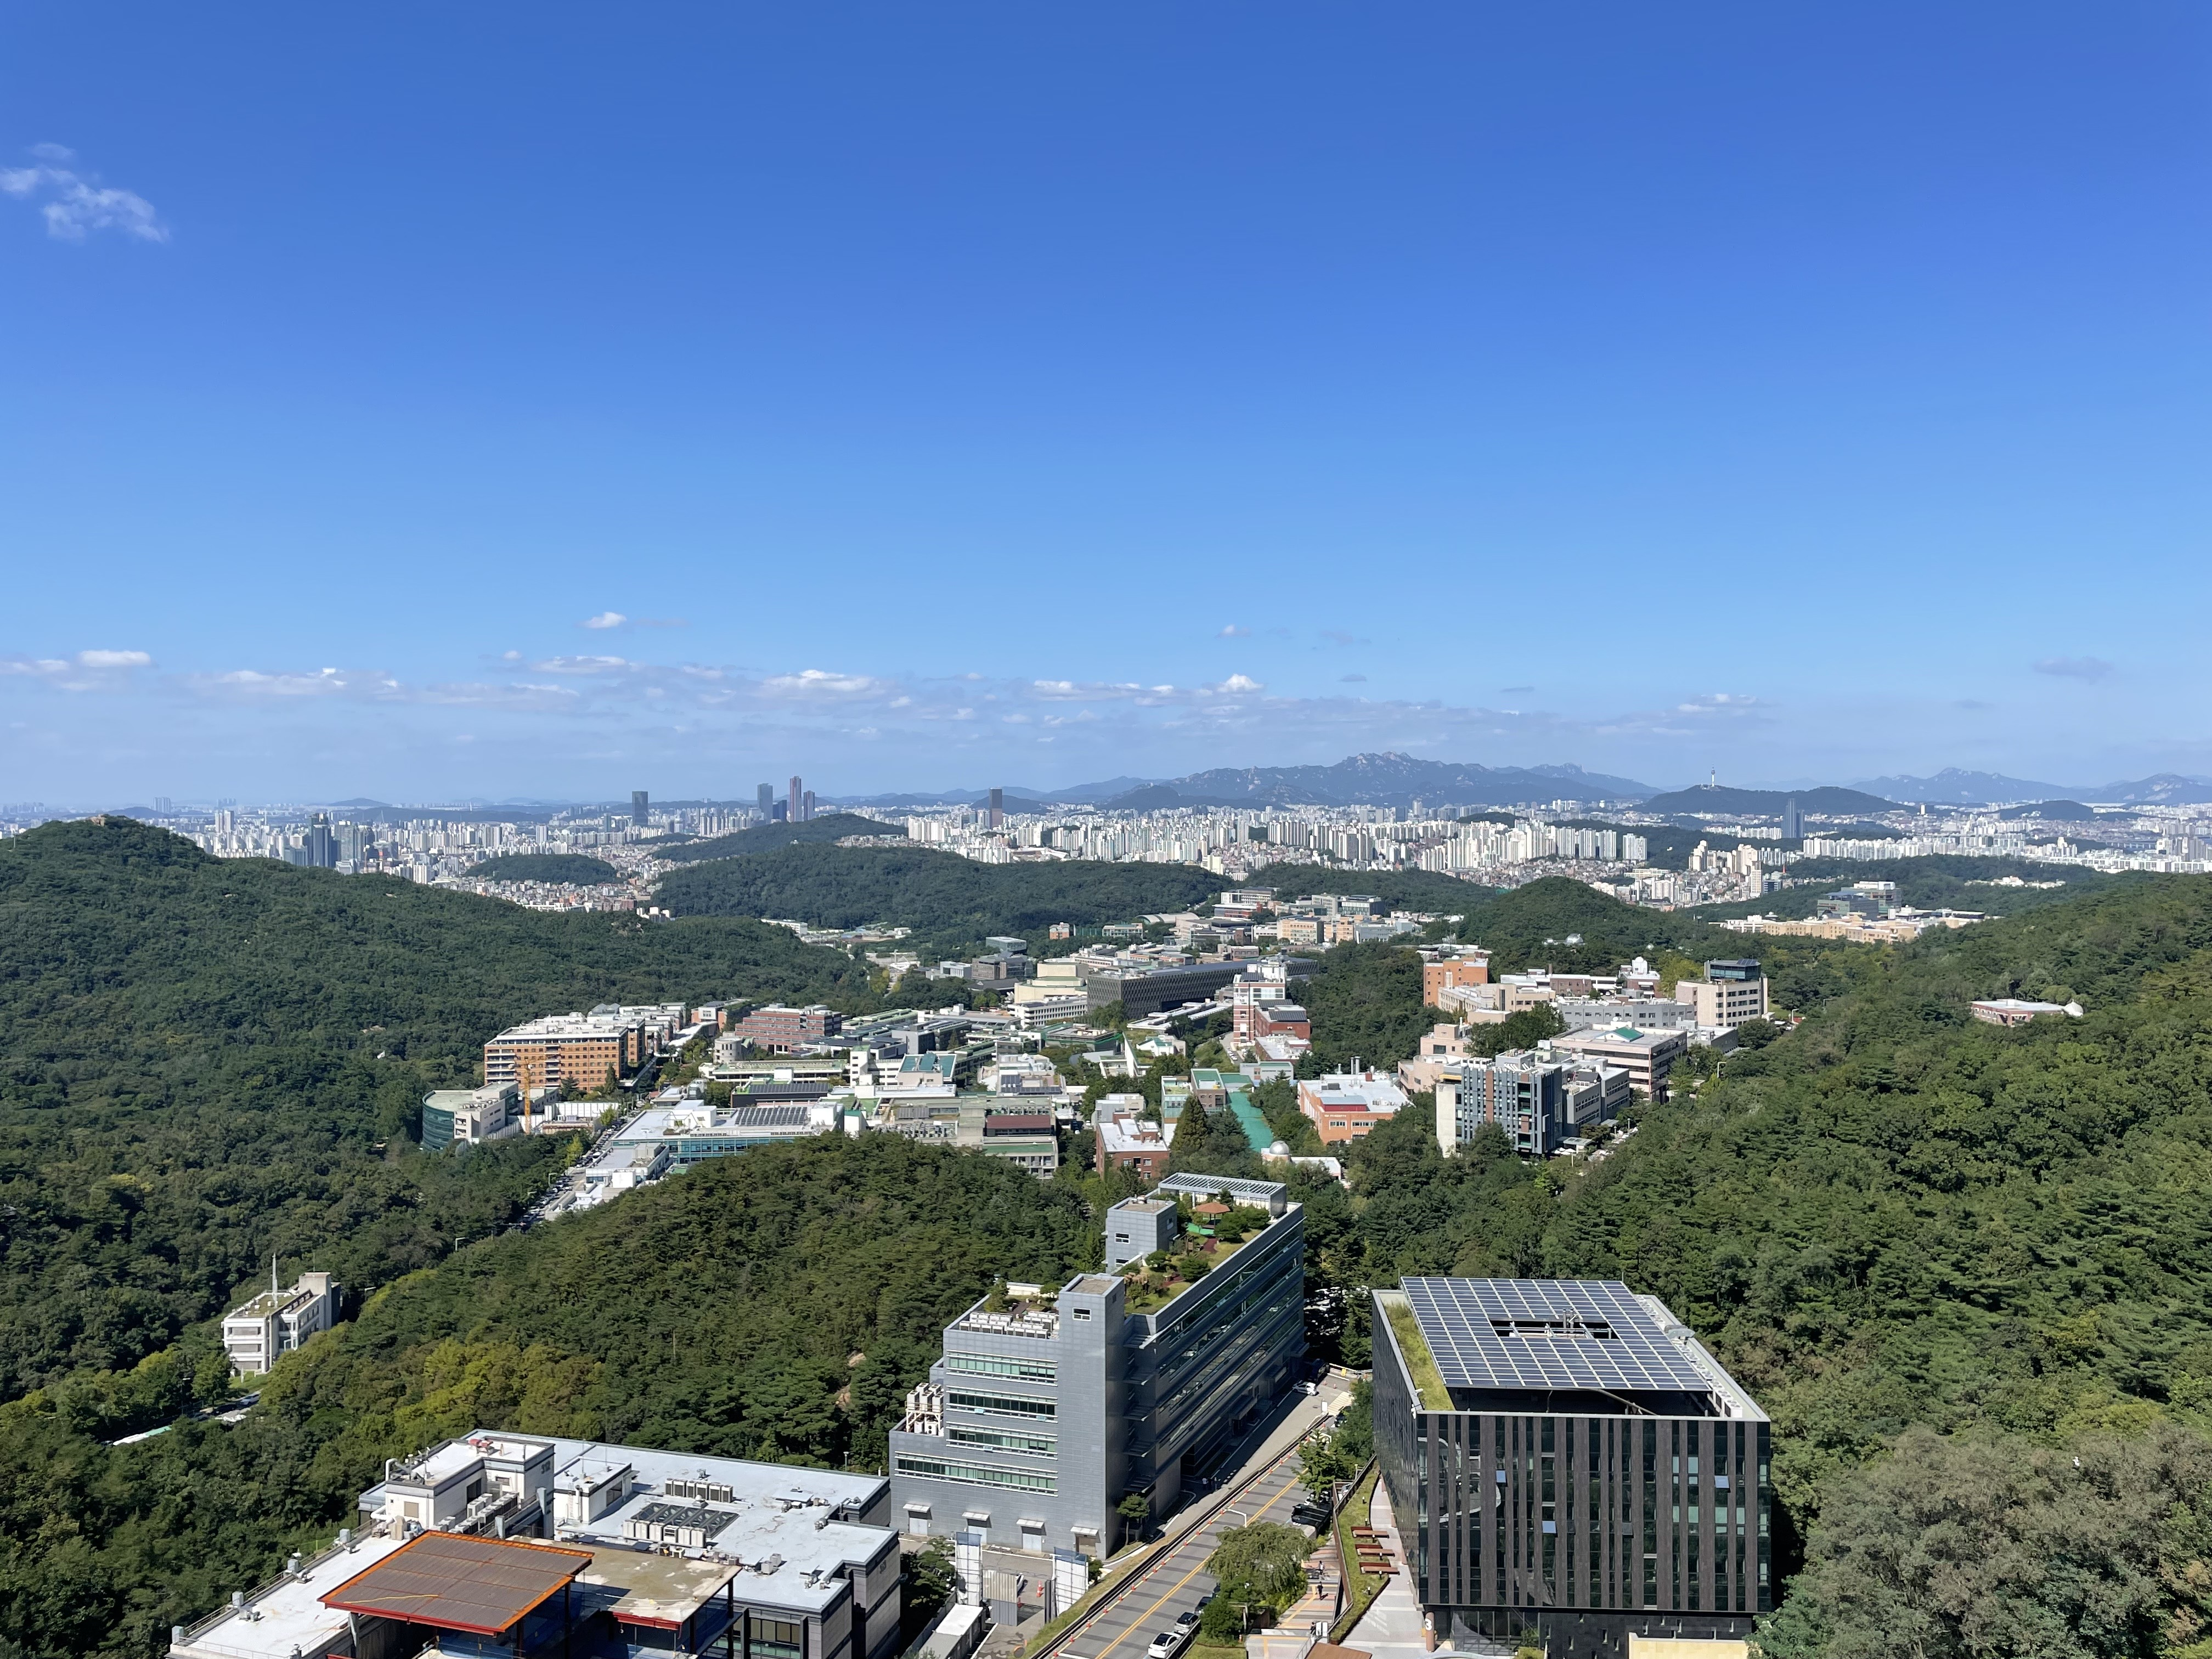

['푸른/시원한']


In [38]:
img_keyword("cafe/101.jpg")

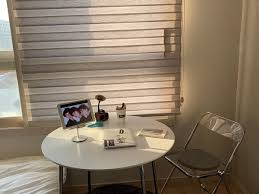

['고급스러운/아늑한/편한', '모던한/깔끔한/평범한']


In [39]:
img_keyword("cafe/99.jpg")

## 1-6 마무리..

sklearn 을 이용한 머신러닝 프로젝트 하나를 끝냈다. 공부한 것을 잘 이용해서 만든것 같아서 다행이다. 

내 생각이지만 데이터셋을 4x4 에서 1x16으로 변환할 때, 가장 주요한 색상부터 데이터셋을 만든게 프로젝트의 성공 요인 같다.<br>
굳이 tensorflow를 이용해서 다시 해볼 필요가 있을까? 라는 생각이 든다! 

하지만 내 모델을 평가할 때, train test셋을 나누지 않은 것이 맘에 걸린다. (9/27)<br>
다른 공부 하기 싫을 때 test셋을 추가해서 새롭게 만들어 봐야겠다.  

크롤링 코드
https://velog.io/@dbstjd0924/%EB%84%A4%EC%9D%B4%EB%B2%84-%EB%A7%9B%EC%A7%91-%ED%81%AC%EB%A1%A4%EB%A7%81%ED%95%98%EA%B8%B0